In [1]:
import numpy as np
import pandas as pd
import clear
import time
import re
import numpy as numpy
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from sklearn import linear_model
plt.style.use(['science', 'no-latex'])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [4]:
# covid_str = '口罩|肺炎|疫情|传染|病毒|冠状|隔离|防控|病例|确诊|新增|卫健委|火神山|公共卫生|防护|钟南山'
# festival_str = '新年|春晚|除夕|春节|大年|鼠年|新春|过年|守岁|新的一年|跨年|元旦|平安夜|圣诞'

# weibo_text = pd.read_csv('weibo_text.csv', usecols=['index', 'text_gsub'])
# weibo_text['is_covid'] = weibo_text['text_gsub'].str.contains(covid_str).astype('int')
# weibo_text['is_festival'] = weibo_text['text_gsub'].str.contains(festival_str).astype('int')

# weibo_senti_label = pd.read_csv('weibo_senti_label.csv')
# weibo_senti_label = pd.merge(weibo_senti_label, weibo_text[['index', 'text_gsub', 'is_covid', 'is_festival']], how='inner', left_on='index', right_on='index')
# weibo_senti_label.sort_values(['label', 'is_covid', 'is_festival', 'index'], inplace=True)
# weibo_senti_label.to_csv('weibo_senti_label2.csv', index=False)


In [4]:
weibo_senti_label = pd.read_csv('weibo_senti_label2.csv', usecols=['index', 'created_at_string', 'senti', 'label', 'is_covid', 'is_festival'])
weibo_senti2 = pd.read_csv('weibo_senti2.csv')
weibo_senti_label = pd.merge(weibo_senti_label, weibo_senti2, how='inner', left_on='index', right_on='index')
new_label = {0:'life', 1:'repost', 2:'covid', 3:'shopping', 4:'festival', 5:'life', 6:'covid', 7:'other', 8:'other', 9:'emoji'}
# new_label_ = {0:'life', 1:'covid', 2:'festival', 3:'repost', 4:'shopping', 5:'emoji', 6:'other'}
weibo_senti_label['new_label'] = weibo_senti_label['label'].apply(lambda x: new_label[x])
weibo_senti_label




,senti_x,index,label,created_at_string,is_covid,is_festival,senti_y,new_label
0,0.128417,2,0,2019-12-30,0,0,0.00,life
1,0.404933,31,0,2019-12-30,0,0,1.00,life
2,0.863085,39,0,2019-12-30,0,0,1.00,life
3,0.431749,40,0,2019-12-30,0,0,-1.00,life
4,0.332698,50,0,2019-12-30,0,0,0.00,life
...,...,...,...,...,...,...,...,...
7473733,1.000000,7961877,9,2020-02-05,1,1,0.69,emoji
7473734,1.000000,7963092,9,2020-02-05,1,1,0.69,emoji
7473735,0.901593,8004885,9,2020-02-05,1,1,-0.11,emoji
7473736,0.971124,8010691,9,2020-02-05,1,1,0.33,emoji


In [5]:
sh_index = pd.read_csv('SH_index.csv', usecols=['日期', '收盘价', '涨跌幅'])
sh_index

,日期,收盘价,涨跌幅
0,2021-03-29,3435.2958,0.4964
1,2021-03-26,3418.3267,1.6273
2,2021-03-25,3363.5915,-0.103
3,2021-03-24,3367.0606,-1.3029
4,2021-03-23,3411.5088,-0.9273
...,...,...,...
7394,1990-12-25,120.2500,4.976
7395,1990-12-24,114.5500,4.9666
7396,1990-12-21,109.1300,4.5407
7397,1990-12-20,104.3900,4.4109


In [6]:
weibo_senti_label = pd.merge(weibo_senti_label, sh_index, how='left', left_on='created_at_string', right_on='日期')
del weibo_senti_label['日期']
weibo_senti_label

,senti_x,index,label,created_at_string,is_covid,is_festival,senti_y,new_label,收盘价,涨跌幅
0,0.128417,2,0,2019-12-30,0,0,0.00,life,3040.0239,1.1643
1,0.404933,31,0,2019-12-30,0,0,1.00,life,3040.0239,1.1643
2,0.863085,39,0,2019-12-30,0,0,1.00,life,3040.0239,1.1643
3,0.431749,40,0,2019-12-30,0,0,-1.00,life,3040.0239,1.1643
4,0.332698,50,0,2019-12-30,0,0,0.00,life,3040.0239,1.1643
...,...,...,...,...,...,...,...,...,...,...
7473733,1.000000,7961877,9,2020-02-05,1,1,0.69,emoji,2818.0878,1.2503
7473734,1.000000,7963092,9,2020-02-05,1,1,0.69,emoji,2818.0878,1.2503
7473735,0.901593,8004885,9,2020-02-05,1,1,-0.11,emoji,2818.0878,1.2503
7473736,0.971124,8010691,9,2020-02-05,1,1,0.33,emoji,2818.0878,1.2503


In [24]:
# weibo_senti_label['收盘价_adj'] = (weibo_senti_label['收盘价']-2600) / 2000

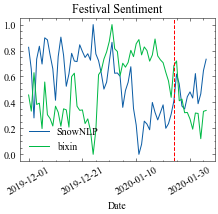

In [7]:
a = weibo_senti_label.groupby(['created_at_string', 'is_festival'])[['senti_x', 'senti_y']].mean().unstack('is_festival').sort_index()
a = (a - a.min()) / (a.max()-a.min())
a.columns = ['x0', 'SnowNLP', 'y0', 'bixin']
# ax = a['SnowNLP'].plot(title='Festival Number', rot=30)
ax = a[['SnowNLP', 'bixin']].plot(title='Festival Sentiment', rot=30)
ax.set_xlabel('Date')
ax.axvline(x=54, ls='--', c='r')
ax

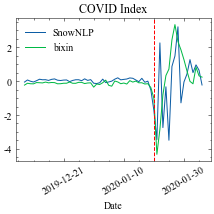

In [8]:
a = weibo_senti_label.groupby(['created_at_string', 'is_covid'])[['senti_x', 'senti_y']].count().unstack('is_covid').sort_index()
a.columns = ['x0', 'SnowNLP_n', 'y0', 'bixin_n']
a['festival_freq'] = a['SnowNLP_n'] / (a['x0']+a['SnowNLP_n'])

b = weibo_senti_label.groupby(['created_at_string', 'is_covid'])[['senti_x', 'senti_y']].mean().unstack('is_covid').sort_index()
b.columns = ['x0', 'SnowNLP', 'y0', 'bixin']
b['SnowNLP_MA7'] = b['SnowNLP']
b['bixin_MA7'] = b['bixin']
for i in range(1, 7):
    b['SnowNLP_MA7'] = b['SnowNLP_MA7'] + b['SnowNLP'].shift(i)
    b['bixin_MA7'] = b['bixin_MA7'] + b['bixin'].shift(i)
b['SnowNLP_MA7'] = b['SnowNLP_MA7'] / 7
b['bixin_MA7'] = b['bixin_MA7'] / 7
b['SnowNLP_MA7_delta'] = b['SnowNLP_MA7'] - b['SnowNLP_MA7'].shift(1)
b['bixin_MA7_delta'] = b['bixin_MA7'] - b['bixin_MA7'].shift(1)

ab = pd.merge(a[['festival_freq']], b[['SnowNLP_MA7_delta', 'bixin_MA7_delta']], how='inner', left_index=True, right_index=True)
# ab.dropna(how='any', inplace=True)
ab['SnowNLP'] = ab['festival_freq'] * ab['SnowNLP_MA7_delta']
ab['bixin'] = ab['festival_freq'] * ab['bixin_MA7_delta']

ab = (ab - ab.mean()) / (ab.std())

ax = ab[['SnowNLP', 'bixin']].plot(title='COVID Index', rot=30)
ax.set_xlabel('Date')
ax.axvline(x=50, ls='--', c='r')
ax

# b = (b - b.min()) / (b.max()-b.min())
# ax = b[['SnowNLP_MA7', 'bixin_MA7']].plot(title='Festival Sentiment MA(7)', rot=30)
# ax.set_xlabel('Date')
# ax.axvline(x=24, ls='--', c='r')
# ax.axvline(x=31, ls='--', c='r')
# ax.axvline(x=54, ls='--', c='r')
# ax

In [72]:
# temp = pd.read_csv('微博大V数据.csv', usecols=['source'])
# temp['index'] = temp.index
# temp['source'].fillna('none', inplace=True)
# temp['source'] = temp['source'].apply(lambda x: re.findall('<a href="(.*?)"', x)[0].split('/')[-1] if len(re.findall('<a href="(.*?)"', x))>0 else np.nan)
# temp.to_csv('weibo_source.csv', index=False)

In [83]:
# weibo_source = pd.read_csv('weibo_source.csv')
# temp = pd.merge(weibo_source, weibo_senti_label[['index', 'created_at_string']], how='right', left_on='index', right_on='index')
# a = temp['source'].value_counts()
# a = a[a>=67]
# filter_s = []
# for s in a.index:
#     if temp[temp['source']==s]['created_at_string'].nunique() == 67:
#         filter_s.append(s)

# temp = temp[temp['source'].isin(filter_s)].copy()
# temp.to_csv('weibo_filter_source.csv', index=False)



In [9]:
weibo_source = pd.read_csv('weibo_filter_source.csv', usecols=['index', 'source'])
weibo_senti_label = pd.merge(weibo_senti_label, weibo_source, how='inner', left_on='index', right_on='index')
weibo_senti_label

,senti_x,index,label,created_at_string,is_covid,is_festival,senti_y,new_label,收盘价,涨跌幅,source
0,0.310345,99,0,2019-12-30,0,0,-1.00,life,3040.0239,1.1643,6vtZb0
1,0.855490,185,0,2019-12-30,0,0,0.00,life,3040.0239,1.1643,6vtZb0
2,0.388145,344,0,2019-12-30,0,0,0.00,life,3040.0239,1.1643,6oAA8r
3,0.817311,448,0,2019-12-30,0,0,1.00,life,3040.0239,1.1643,2F3i7o
4,0.805829,450,0,2019-12-30,0,0,0.00,life,3040.0239,1.1643,6vtZb0
...,...,...,...,...,...,...,...,...,...,...,...
5596620,0.991427,7931322,9,2020-02-05,1,1,0.31,emoji,2818.0878,1.2503,3kdgj1
5596621,0.999997,7943016,9,2020-02-05,1,1,1.00,emoji,2818.0878,1.2503,1tqBja
5596622,1.000000,7955260,9,2020-02-05,1,1,0.65,emoji,2818.0878,1.2503,5B6hUc
5596623,0.971124,8010691,9,2020-02-05,1,1,0.33,emoji,2818.0878,1.2503,6vtZb0


In [10]:
# senti_... ~ is_... * post_...
ols_df = weibo_senti_label[['created_at_string', 'senti_x', 'senti_y', 'is_covid', 'is_festival', 'source']].copy()
# ols_df = ols_df.groupby(['source', 'created_at_string', 'is_covid'])[['senti_x', 'senti_y']].mean().reset_index()
ols_df = ols_df.groupby(['source', 'created_at_string', 'is_festival'])[['senti_x', 'senti_y']].mean().reset_index()

# ols_df['post_covid'] = (ols_df['created_at_string']>='2020-01-20').astype('int')
# ols_df['is_post_covid'] = ols_df['is_covid'] * ols_df['post_covid']
ols_df['post_festival'] = (ols_df['created_at_string']>='2020-01-24').astype('int')
ols_df['is_post_festival'] = ols_df['is_festival'] * ols_df['post_festival']

ols_df['created_at_string'] = pd.to_datetime(ols_df['created_at_string'])
ols_df.set_index(['source', 'created_at_string'], inplace=True)
# x = sm.add_constant(ols_df[['is_post_covid']])
x = sm.add_constant(ols_df[['is_post_festival']])
ols_data_fe = PanelOLS(ols_df['senti_x'], x, entity_effects=True, time_effects=True)
res = ols_data_fe.fit()
res

Dep. Variable:,senti_x,R-squared:,8.257e-05
Estimator:,PanelOLS,R-squared (Between):,-0.0008
No. Observations:,26737,R-squared (Within):,-0.0016
Date:,"Tue, Apr 06 2021",R-squared (Overall):,-0.0013
Time:,19:12:45,Log-likelihood,8094.2
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.1822
Entities:,245,P-value,0.1396
Avg Obs:,109.13,Distribution:,"F(1,26425)"
Min Obs:,67.000,,
Max Obs:,134.00,F-statistic (robust):,2.1822


In [36]:
# senti_... ~ is_... * post_...
comp = {'life': 0, 'repost': 1}
ols_df = weibo_senti_label[['created_at_string', 'senti_x', 'senti_y', 'new_label', 'source']].copy()
ols_df = ols_df[ols_df['new_label'].isin(comp.keys())].copy()
ols_df['new_label'] = ols_df['new_label'].apply(lambda x: comp[x])
# ols_df = ols_df.groupby(['source', 'created_at_string', 'is_covid'])[['senti_x', 'senti_y']].mean().reset_index()
ols_df = ols_df.groupby(['source', 'created_at_string', 'new_label'])[['senti_x', 'senti_y']].mean().reset_index()

ols_df['post_covid'] = (ols_df['created_at_string']>='2020-01-20').astype('int')
ols_df['is_post_covid'] = ols_df['new_label'] * ols_df['post_covid']
# ols_df['post_festival'] = (ols_df['created_at_string']>='2020-01-24').astype('int')
# ols_df['is_post_festival'] = ols_df['is_festival'] * ols_df['post_festival']

ols_df['created_at_string'] = pd.to_datetime(ols_df['created_at_string'])
ols_df.set_index(['source', 'created_at_string'], inplace=True)
x = sm.add_constant(ols_df[['is_post_covid']])
# x = sm.add_constant(ols_df[['is_post_festival']])
ols_data_fe = PanelOLS(ols_df['senti_y'], x, entity_effects=True, time_effects=True)
res = ols_data_fe.fit()
res

Dep. Variable:,senti_y,R-squared:,0.0007
Estimator:,PanelOLS,R-squared (Between):,-0.0114
No. Observations:,26080,R-squared (Within):,0.0052
Date:,"Wed, Apr 07 2021",R-squared (Overall):,0.0062
Time:,23:24:33,Log-likelihood,1763.0
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.007
Entities:,244,P-value,0.0000
Avg Obs:,106.89,Distribution:,"F(1,25769)"
Min Obs:,8.0000,,
Max Obs:,134.00,F-statistic (robust):,17.007


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 20851 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 24494 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 21338 missing from current font.
  font.set_text

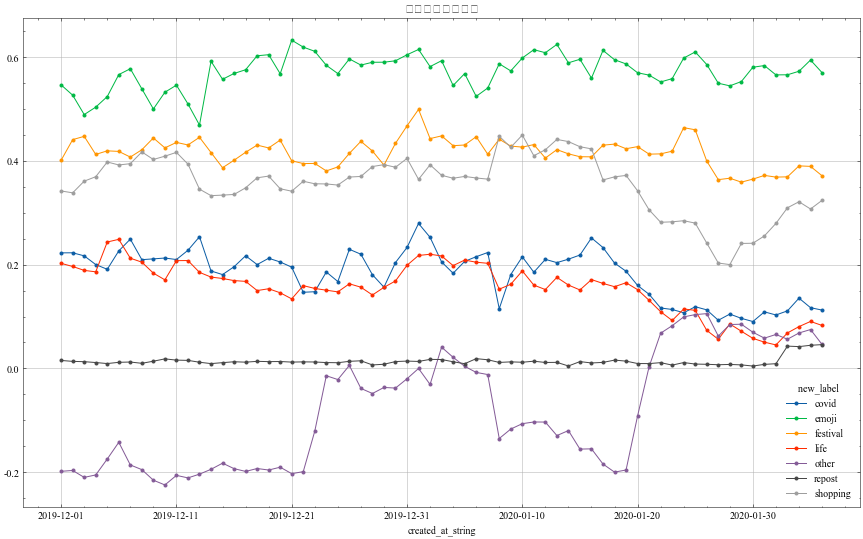

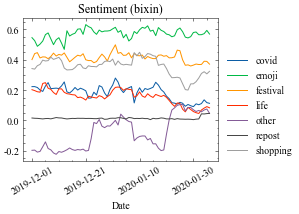

In [37]:
stock_df = weibo_senti_label[['created_at_string', 'senti_x', 'senti_y', '收盘价', 'new_label']].copy()
stock_df = stock_df.groupby(['created_at_string', 'new_label'])[['senti_x', 'senti_y', '收盘价']].mean().reset_index()

# stock_df['new_label'] = stock_df['new_label'].apply(lambda x: new_label_[x])
stock_df.set_index(['created_at_string', 'new_label'])[['senti_x', 'senti_y']].unstack('new_label')['senti_y'].plot(figsize=(15,9), style='.-', grid=True, title='疫情相关微博条数')

ax = ((stock_df.set_index(['created_at_string', 'new_label'])[['senti_x', 'senti_y']].unstack('new_label')['senti_y']+0)/1).plot(title='Sentiment (bixin)', rot=30)
ax.set_xlabel('Date')
ax.legend(bbox_to_anchor=(1, 0.8), ncol=1)
ax


In [340]:
# stock_x = stock_df.set_index(['created_at_string', 'new_label'])[['senti_x', 'senti_y']].unstack('new_label')
# ols_df = weibo_senti_label[['created_at_string', 'senti_x', 'senti_y', 'is_covid', 'is_festival']].copy()
# ols_df['is_covid_string'] = ols_df['is_covid'].apply(lambda x: 'is_covid' if x else 'no_covid')
# ols_df['is_fes_string'] = ols_df['is_festival'].apply(lambda x: 'is_fes' if x else 'no_fes')
# stock_covid = ols_df.groupby(['created_at_string', 'is_covid_string'])[['senti_x', 'senti_y']].mean().unstack('is_covid_string')
# stock_fes = ols_df.groupby(['created_at_string', 'is_fes_string'])[['senti_x', 'senti_y']].mean().unstack('is_fes_string')
# stock_x = pd.merge(stock_x, stock_covid, how='inner', left_index=True, right_index=True)
# stock_x = pd.merge(stock_x, stock_fes, how='inner', left_index=True, right_index=True)

# stock_y = stock_df.set_index(['created_at_string', 'new_label'])[['收盘价']].unstack('new_label')
# stock_xy = pd.merge(stock_x, stock_y, how='inner', left_index=True, right_index=True)
# stock_xy['price_shift'] = stock_xy['收盘价']['covid'].shift(0)
# del stock_xy['收盘价']
# stock_xy.dropna(how='any', inplace=True)

x = sm.add_constant(stock_xy['senti_x'][['shopping']])
ols_data_fe = sm.OLS(stock_xy['price_shift'], x)
res = ols_data_fe.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_shift   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     52.78
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           9.29e-09
Time:                        19:46:44   Log-Likelihood:                -226.46
No. Observations:                  41   AIC:                             456.9
Df Residuals:                      39   BIC:                             460.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2074.4934    126.995     16.335      0.000    1817.622    2331.364
shopping    1702.9298    234.396      7.265      0.000    1228.819    2177.040
==============================================================================
Omnibus:                        0.630   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.713
Skew:                           0.128   Prob(JB):                        0.700
Kurtosis:                       2.407   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
regre=linear_model.LinearRegression()
regre.fit(stock_xy['senti_x'][['shopping', 'is_covid']][:-3], stock_xy['price_shift'][:-3])
regre.coef_

array([1288.68887376, -359.11675688])

In [229]:
print(regre.predict(stock_xy['senti_x'][['shopping', 'is_covid']][-3:]))
stock_xy['price_shift'][-3:]

[2937.42353881 2922.1553563  2916.50921863]


created_at_string
2020-02-02    2746.6056
2020-02-03    2783.2875
2020-02-04    2818.0878
Name: price_shift, dtype: float64

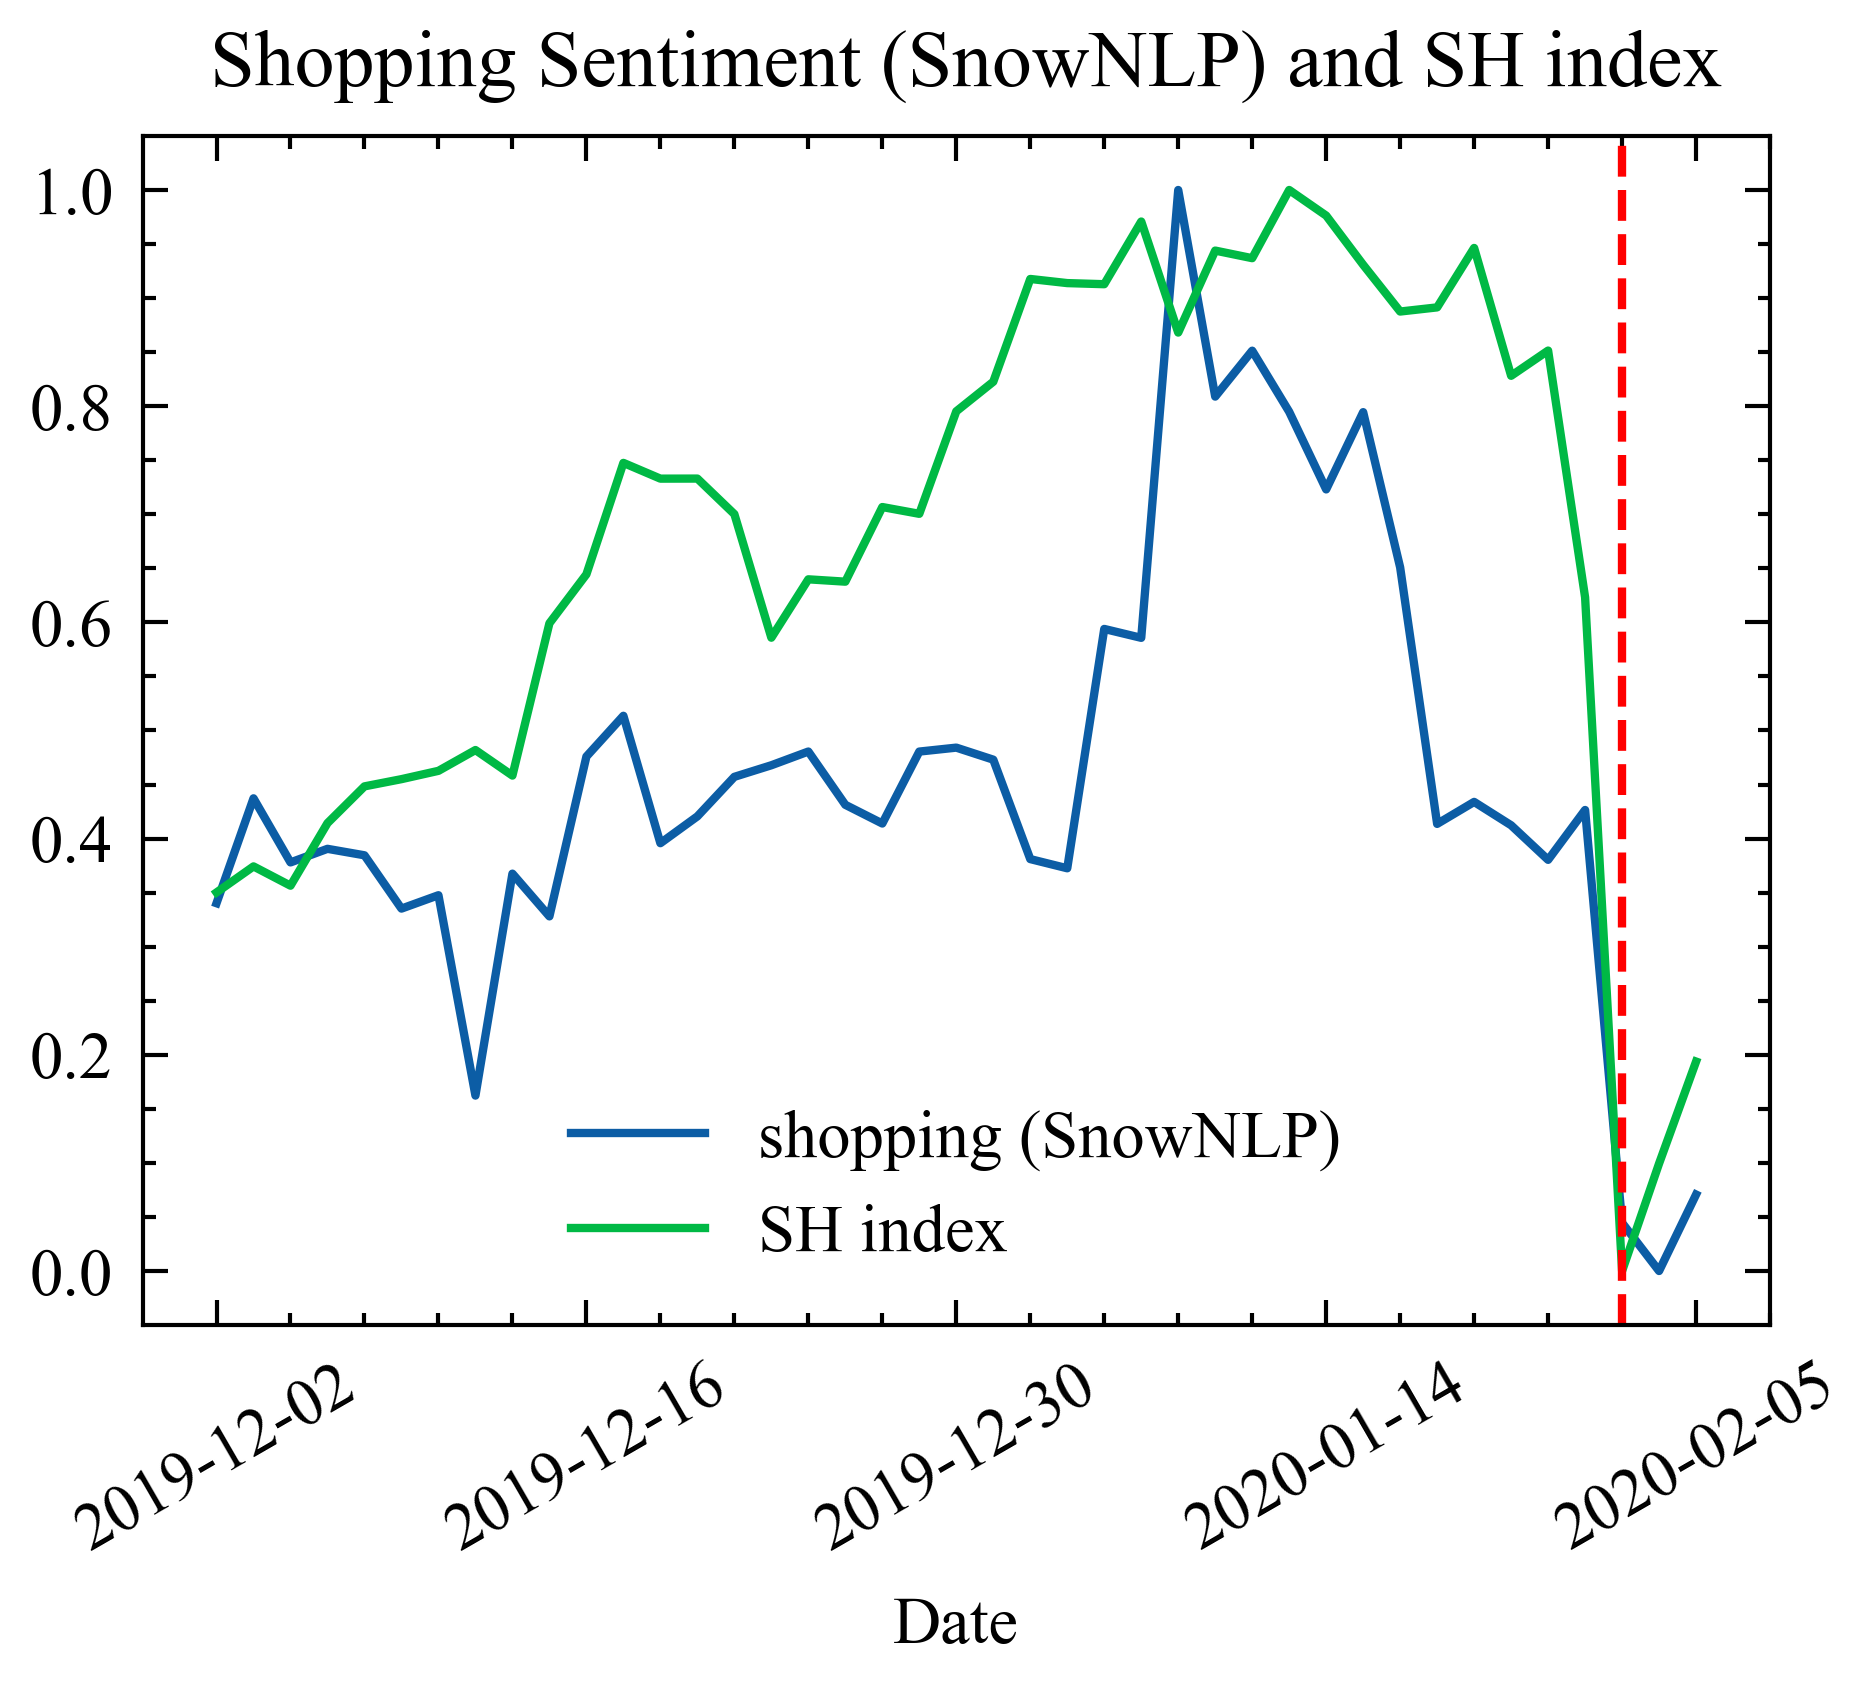

In [350]:
s = stock_xy.copy()
s.columns = [c1+'_'+c0[-1] for c0,c1 in zip(s.columns.get_level_values(0)[:-1], s.columns.get_level_values(1)[:-1])]+['price_shift']
s.rename(columns={'shopping_x': 'shopping (SnowNLP)', 'price_shift':'SH index'}, inplace=True)
s = (s - s.min()) / (s.max() - s.min())

ax = s[['shopping (SnowNLP)', 'SH index']].plot(title=' Shopping Sentiment (SnowNLP) and SH index', rot=30)
ax.set_xlabel('Date')
ax.axvline(x=38, ls='--', c='r')
ax